In [ ]:
from dotenv import load_dotenv

load_dotenv()

True

In [1]:
from typing import List
from langchain_core.messages import SystemMessage
from langchain_openai import ChatOpenAI
from pydantic import BaseModel

### 사용자로부터 요구사항 수집
사용자 요구사항을 수집하는 노드를 정의

사용자에게 구체적인 정보를 요구할 수 있음. 필요한 정보가 모두 충족될 때까지 사용자에게 필요한 정보를 요구함

In [2]:
# 사용자 요구사항 수집을 위한 시스템 메세지 템플릿
template = """Your job is to get information from a user about what type of prompt template they want to create.

You should get the following information from them:

- What the objective of the prompt is
- What variables will be passed into the prompt template
- Any constraints for what the output should NOT do
- Any requirements that the output MUST adhere to

If you are not able to discern this info, ask them to clarify! Do not attempt to wildly guess.

After you are able to discern all the information, call the relevant tool.

[IMPORTANT] Your conversation should be in Korean. Your generated prompt should be in English.
"""


# 사용자 메세지 목록을 받아 시스템 메세지와 결합하여 반환
def get_messages_info(messages):
    # 사용자 요구사항 수집을 위한 시스템 메세지와 기존 메세지 결합
    return [SystemMessage(content=template)] + messages


# LLM에 대한 프롬프트 지침을 정의하는 데이터 모델
class PromptIntructions(BaseModel):
    """Intructions on how to prompt the LLM."""

    # 프롬프트의 목표
    objective: str
    # 프롬프트 템플릿에 전달된 변수 목록
    variables: List[str]
    # 출력에서 피해야 할 제약 조건 목록
    constraints: List[str]
    # 출력이 반드시 따라야 할 요구 사항 목록
    requirements: List[str]


# 최신 LLM 모델 이름 가져오기
MODEL_NAME = "gpt-4o-mini"
# LLM 초기화
llm = ChatOpenAI(temperature=0, model=MODEL_NAME)
# PromptInstructions 구조체를 바인딩
llm_with_tool = llm.bind_tools([PromptIntructions])


# 상태 정보를 기반으로 메세지 체인을 생성하고 LLM 호출
def info_chain(state):
    # 상태에서 메세지 정보를 가져와 시스템 메세지와 결합
    messages = get_messages_info(state["messages"])
    # LLM을 호출하여 응답 생성
    response = llm_with_tool.invoke(messages)
    return {"messages": [response]}

### 프롬프트 생성
프롬프트를 생성할 상태를 설정
- 이를 위한 별도의 시스템 메세지가 필요하며, 도구 호출 이전의 모든 메세지를 필터링하는 함수도 필요함
**메타 프롬프트(Meta Prompt)의 정의**
메타 프롬프트(Meta Prompt)는 프롬프트 설계 및 생성 자체를 최적화하기 위한 방법론이나 전략을 지칭하는 개념
- LLM을 보다 효과적이고 효율적으로 활용하기 위해 사용
텍스트를 입력하는 것을 넘어 모델의 반응을 특정 방식으로 유도하거나, 결과의 품질을 높이는 데 필요한 구조적이고 창의적인 접근을 포함

주요 특징
1. 목표 지향적 구조
   - 결과로 얻고자 하는 정보를 명확히 정의하고, 이를 위한 단계별 설계 과정을 포함
2. 적응형 설계
   - 모델의 답변 특성, 한계, 강점을 고려하여 프롬프트를 수정하거나 반복적으로 최적화하는 접근 방식을 포함
3. 프롬프트 엔지니어링 활용
   - 조건문, 가이드라인, 역할 지시 등을 포함하여 모델의 응답을 세밀하게 조정 
4. 다층적 접근
   - 단일 질문에 그치지 않고, 하위 질문을 통해 답변을 점진적으로 구체화하는 방식을 채택

In [3]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage, SystemMessage

# 프롬프트를 생성하는 메타 프롬프트 정의
META_PROMPT = """Given a task description or existing prompt, produce a detailed system prompt to guide a language model in completing the task effectively.

# Guidelines

- Understand the Task: Grasp the main objective, goals, requirements, constraints, and expected output.
- Minimal Changes: If an existing prompt is provided, improve it only if it's simple. For complex prompts, enhance clarity and add missing elements without altering the original structure.
- Reasoning Before Conclusions**: Encourage reasoning steps before any conclusions are reached. ATTENTION! If the user provides examples where the reasoning happens afterward, REVERSE the order! NEVER START EXAMPLES WITH CONCLUSIONS!
    - Reasoning Order: Call out reasoning portions of the prompt and conclusion parts (specific fields by name). For each, determine the ORDER in which this is done, and whether it needs to be reversed.
    - Conclusion, classifications, or results should ALWAYS appear last.
- Examples: Include high-quality examples if helpful, using placeholders [in brackets] for complex elements.
   - What kinds of examples may need to be included, how many, and whether they are complex enough to benefit from placeholders.
- Clarity and Conciseness: Use clear, specific language. Avoid unnecessary instructions or bland statements.
- Formatting: Use markdown features for readability. DO NOT USE ``` CODE BLOCKS UNLESS SPECIFICALLY REQUESTED.
- Preserve User Content: If the input task or prompt includes extensive guidelines or examples, preserve them entirely, or as closely as possible. If they are vague, consider breaking down into sub-steps. Keep any details, guidelines, examples, variables, or placeholders provided by the user.
- Constants: DO include constants in the prompt, as they are not susceptible to prompt injection. Such as guides, rubrics, and examples.
- Output Format: Explicitly the most appropriate output format, in detail. This should include length and syntax (e.g. short sentence, paragraph, JSON, etc.)
    - For tasks outputting well-defined or structured data (classification, JSON, etc.) bias toward outputting a JSON.
    - JSON should never be wrapped in code blocks (```) unless explicitly requested.

The final prompt you output should adhere to the following structure below. Do not include any additional commentary, only output the completed system prompt. SPECIFICALLY, do not include any additional messages at the start or end of the prompt. (e.g. no "---")

[Concise instruction describing the task - this should be the first line in the prompt, no section header]

[Additional details as needed.]

[Optional sections with headings or bullet points for detailed steps.]

# Steps [optional]

[optional: a detailed breakdown of the steps necessary to accomplish the task]

# Output Format

[Specifically call out how the output should be formatted, be it response length, structure e.g. JSON, markdown, etc]

[User given variables should be wrapped in {{brackets}}]

<Question>
{{question}}
</Question>

<Answer>
{{answer}}
</Answer>

# Examples [optional]

[Optional: 1-3 well-defined examples with placeholders if necessary. Clearly mark where examples start and end, and what the input and output are. User placeholders as necessary.]
[If the examples are shorter than what a realistic example is expected to be, make a reference with () explaining how real examples should be longer / shorter / different. AND USE PLACEHOLDERS! ]

# Notes [optional]

[optional: edge cases, details, and an area to call or repeat out specific important considerations]

# Based on the following requirements, write a good prompt template:

{reqs}
"""


# 프롬프트 생성을 위한 메세지 가져오기 함수
# 도구 호출 이후의 메세지만 가져옴
def get_prompt_messages(messages: list):
    # 도구 호출 정보를 저장할 변수 초기화
    tool_call = None
    # 도구 호출 이후의 메세지를 저장할 리스트 초기화
    other_msgs = []
    # 메세지 목록을 순회하며 도구 호출 및 기타 메세지 처리
    for m in messages:
        # AI 메세지 중 도구 호출이 있는 경우 도구 호출 정보 저장
        if isinstance(m, AIMessage) and m.tool_calls:
            tool_call = m.tool_calls[0]["args"]
        # ToolMessage는 건너뛰기
        elif isinstance(m, ToolMessage):
            continue
        # 도구 호출 이후의 메세지를 리스트에 추가
        elif tool_call is not None:
            other_msgs.append(m)
    # 시스템 메세지와 도구 호출 이후의 메세지를 결합하여 반환
    return [SystemMessage(content=META_PROMPT.format(reqs=tool_call))] + other_msgs


# 프롬프트 생성 체인 함수 정의
def prompt_gen_chain(state):
    # 상태에서 프롬프트 메세지를 가져옴
    messages = get_prompt_messages(state["messages"])
    # LLM을 호출하여 응답 생성
    response = llm.invoke(messages)
    return {"messages": [response]}

### 상태 논리 정의
챗봇의 상태를 결정하는 논리를 설명
- 마지막 메세지가 `tool_call`인 경우 "prompt creator"(`prompt`)가 응답해야 하는 상태
- 마지막 메세지가 `HumanMessage`가 아닌 경우, 사용자가 다음에 응답해야 하므로 `END` 상태에 있음
- 마지막 메세지가 `HumanMessage`인 경우, 이전에 `tool_call`이 있었다면 `prompt`상태에 있음
- 그렇지 않으면 "정보 수집"(`info`) 상태에 있음

In [4]:
from langgraph.graph import END


# 상태 결정 함수 정의
# 상태에서 메세지 목록을 가져옴
def get_state(state):
    messages = state["messages"]
    # 마지막 메세지가 AIMessage이고 도구 호출이 있는 경우
    if isinstance(messages[-1], AIMessage) and messages[-1].tool_calls:
        # 도구 메세지를 추가해야 하는 상태 반환
        return "add_tool_message"
    # 마지막 메세지가 HumanMessage가 아닌 경우
    elif not isinstance(messages[-1], HumanMessage):
        # 대화 종료 상태 반환
        return END
    # 기본적으로 정보 수집 상태 반환
    return "info"

### 그래프 생성

In [5]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import ToolMessage
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict


# state 정의
class State(TypedDict):
    messages: Annotated[list, add_messages]


# 메모리에 대화 기록을 저장하기 위한 MemorySaver 초기화
memory = MemorySaver()

# 상태 그래프 초기화
workflow = StateGraph(State)

# 노드 추가
workflow.add_node("info", info_chain)
workflow.add_node("prompt", prompt_gen_chain)


# 도구 메세지 추가 상태 노드 정의
@workflow.add_node
def add_tool_message(state: State):
    return {
        "messages": [
            ToolMessage(
                content="Prompt generated!",
                tool_call_id=state["messages"][-1].tool_calls[0][
                    "id"
                ],  # 상태에서 도구 호출 ID를 가져와 메세지에 추가
            )
        ]
    }


# 조건부 상태 전환 정의
workflow.add_conditional_edges("info", get_state, ["add_tool_message", "info", END])

# 엣지 정의
workflow.add_edge("add_tool_message", "prompt")
workflow.add_edge("prompt", END)
workflow.add_edge(START, "info")

# 그래프 컴파일
graph = workflow.compile(checkpointer=memory)

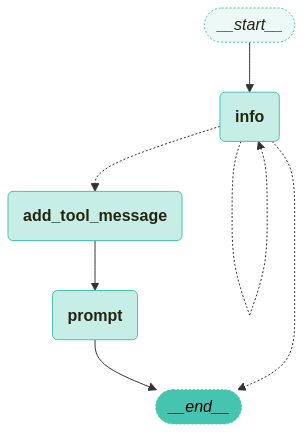

In [9]:
from dataclasses import dataclass


@dataclass
class NodeStyles:
    default: str = (
        "fill:#45C4B0, fill-opacity:0.3, color:#23260F, stroke:#45C4B0, stroke-width:1px, font-weight:bold, line-height:1.2"  # 기본 색상
    )
    first: str = (
        "fill:#45C4B0, fill-opacity:0.1, color:#23260F, stroke:#45C4B0, stroke-width:1px, font-weight:normal, font-style:italic, stroke-dasharray:2,2"  # 점선 테두리
    )
    last: str = (
        "fill:#45C4B0, fill-opacity:1, color:#000000, stroke:#45C4B0, stroke-width:1px, font-weight:normal, font-style:italic, stroke-dasharray:2,2"  # 점선 테두리
    )


from IPython.display import Image, display
from langgraph.graph.state import CompiledStateGraph

if isinstance(graph, CompiledStateGraph):
    display(
        Image(
            graph.get_graph(xray=False).draw_mermaid_png(
                background_color="white",
                node_colors=NodeStyles(),
            )
        )
    )

In [11]:
import uuid
import os

os.chdir("..")
from tools.messages import stream_graph

# 구성 설정 초기화(고유한 thread_id 생성)
config = {"configurable": {"thread_id": str(uuid.uuid4())}}

# 무한 루프 시작
while True:
    try:
        # 사용자 입력 받기
        user = input("User (q/Q to quit): ")
    except:
        pass

    # 사용자 입력 출력
    print(f"\n\033[93m[사용자] {user}\033[0m")

    # q 또는 Q를 입력하면 루프 종료
    if user in {"q", "Q"}:
        print("AI: 다음에 또 만나요!")
        break

    # 출력 변수 초기화
    output = None

    stream_graph(
        graph,
        {"messages": [HumanMessage(content=user)]},
        config=config,
        node_names=["info", "prompt"],
    )


[사용자] 

🔄 Node: info 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
안녕하세요! 어떤 종류의 프롬프트 템플릿을 만들고 싶으신가요? 다음 정보를 알려주시면 도움이 될 것 같습니다:

1. 프롬프트의 목적은 무엇인가요?
2. 프롬프트 템플릿에 전달될 변수는 무엇인가요?
3. 출력에서 하지 말아야 할 제약 조건은 무엇인가요?
4. 출력이 반드시 준수해야 할 요구 사항은 무엇인가요?

이 정보를 제공해 주시면, 적절한 프롬프트 템플릿을 생성하는 데 도움을 드리겠습니다!
[사용자] pdf 기반 챗봇을 만들고 싶어

🔄 Node: info 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
PDF 기반 챗봇을 만들고 싶으시군요! 좀 더 구체적인 정보를 제공해 주시면 좋겠습니다. 다음 질문에 답해 주실 수 있나요?

1. 프롬프트의 목적은 무엇인가요? (예: 사용자가 PDF에서 정보를 검색할 수 있도록 돕기)
2. 프롬프트 템플릿에 전달될 변수는 무엇인가요? (예: PDF 파일 경로, 사용자 질문 등)
3. 출력에서 하지 말아야 할 제약 조건은 무엇인가요? (예: 부정확한 정보 제공 금지)
4. 출력이 반드시 준수해야 할 요구 사항은 무엇인가요? (예: 명확하고 간결한 답변 제공)

이 정보를 알려주시면, 프롬프트 템플릿을 생성하는 데 도움이 될 것입니다!
[사용자] 목적은 pdf를 읽고 사용자가 원하는 정보를 추출해주는거야

🔄 Node: info 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
목적이 "PDF를 읽고 사용자가 원하는 정보를 추출해주는 것"이라고 하셨군요. 다음으로, 추가 정보를 부탁드립니다:

2. 프롬프트 템플릿에 전달될 변수는 무엇인가요? (예: PDF 파일 경로, 사용자 질문 등)
3. 출력에서 하지 말아야 할 제약 조건은 무엇인가요? (예: 부정확한 정보 제공 금지)
4. 출력이 반드시 준수해